In [6]:
!pip -q install librosa soundfile umap-learn

In [19]:
import os, random
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

import librosa
import soundfile as sf

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, adjusted_rand_score

import matplotlib.pyplot as plt

In [18]:
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
import kagglehub
kagglehub.dataset_download("thisisjibon/banglabeats3sec")

Using Colab cache for faster access to the 'banglabeats3sec' dataset.


'/kaggle/input/banglabeats3sec'

In [10]:
MANIFEST = "/content/drive/MyDrive/hybrid_dataset/hybrid_en_bn_3sec_30000_manifest.csv"

OUT_DIR = Path("/content/drive/MyDrive/easy_task_outputs")
OUT_DIR.mkdir(parents=True, exist_ok=True)

CACHE_DIR = Path("/content/drive/MyDrive/easy_task_cache")
CACHE_DIR.mkdir(parents=True, exist_ok=True)

print("OUT_DIR:", OUT_DIR)
print("CACHE_DIR:", CACHE_DIR)

OUT_DIR: /content/drive/MyDrive/easy_task_outputs
CACHE_DIR: /content/drive/MyDrive/easy_task_cache


In [11]:
df = pd.read_csv(MANIFEST)
print(df.shape)
print(df["language"].value_counts())
df.head()

(30000, 17)
language
english    15000
bengali    15000
Name: count, dtype: int64


,song_id,clip_idx,abs_t0,abs_t1,rel_t0,rel_t1,clip_path,language,source_dataset,genres,lyrics_text,lyrics_len,clip_uid,language_id,has_lyrics,word_count,char_count
0,8247bc1d70ba4c4a9a9ae8cad93480ff,6,48.0,51.0,18.0,21.0,/content/drive/MyDrive/dali_en_clips_3s/c3d765...,english,dali,Pop,i've searched for the perfect love all my life,46,dali::8247bc1d70ba4c4a9a9ae8cad93480ff::6,0,True,9,46
1,Adhunik__000167,2,6.0,9.0,6.0,9.0,/kaggle/input/banglabeats3sec/wavs3sec/Adhunik...,bengali,banglabeats,Adhunik,NaN,0,banglabeats::Adhunik__000167::2,1,False,0,0
2,Rock__000184,1,3.0,6.0,3.0,6.0,/kaggle/input/banglabeats3sec/wavs3sec/Rock/18...,bengali,banglabeats,Rock,NaN,0,banglabeats::Rock__000184::1,1,False,0,0
3,Folk__000014,2,6.0,9.0,6.0,9.0,/kaggle/input/banglabeats3sec/wavs3sec/Folk/14...,bengali,banglabeats,Folk,NaN,0,banglabeats::Folk__000014::2,1,False,0,0
4,743189d4a1cc4dadbb7312d3b17defaf,3,39.0,42.0,9.0,12.0,/content/drive/MyDrive/dali_en_clips_3s/c3d765...,english,dali,"Jazz,Pop",and children listen to hear sleigh bells in th...,53,dali::743189d4a1cc4dadbb7312d3b17defaf::3,0,True,10,53


In [12]:
def extract_mfcc_features(path, sr=22050, n_mfcc=40):
    y, _ = librosa.load(path, sr=sr, mono=True)

    # amplitude normalize (reduces loudness bias)
    peak = np.max(np.abs(y)) + 1e-8
    y = y / peak

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
    d1 = librosa.feature.delta(mfcc)
    d2 = librosa.feature.delta(mfcc, order=2)

    feats = np.concatenate([
        mfcc.mean(axis=1), mfcc.std(axis=1),
        d1.mean(axis=1), d1.std(axis=1),
        d2.mean(axis=1), d2.std(axis=1),
    ], axis=0).astype(np.float32)

    return feats  # shape = 6*n_mfcc

In [15]:
X_NPY = CACHE_DIR / f"X_mfcc_norm_{len(df)}.npy"
Y_NPY = CACHE_DIR / f"y_lang_{len(df)}.npy"
META_CSV = CACHE_DIR / f"meta_{len(df)}.csv"

if X_NPY.exists() and Y_NPY.exists() and META_CSV.exists():
    X = np.load(X_NPY)
    y_lang = np.load(Y_NPY)
    meta = pd.read_csv(META_CSV)
    print("Loaded cached:", X.shape, y_lang.shape, meta.shape)
else:
    X_list, y_list, meta_rows = [], [], []
    bad = 0

    for _, r in tqdm(df.iterrows(), total=len(df), desc="MFCC extraction"):
        p = str(r["clip_path"])
        try:
            feats = extract_mfcc_features(p, sr=22050, n_mfcc=40)
            X_list.append(feats)
            y_list.append(0 if r["language"]=="english" else 1)
            meta_rows.append({
                "clip_path": p,
                "language": r["language"],
                "genres": r.get("genres", ""),
                "source_dataset": r.get("source_dataset", "")
            })
        except Exception:
            bad += 1

    X = np.stack(X_list, axis=0)
    y_lang = np.array(y_list, dtype=np.int32)
    meta = pd.DataFrame(meta_rows)

    np.save(X_NPY, X)
    np.save(Y_NPY, y_lang)
    meta.to_csv(META_CSV, index=False)

    print("Saved cache:", X.shape, y_lang.shape, meta.shape, "bad:", bad)

X.shape

MFCC extraction:   0%|          | 0/30000 [00:00<?, ?it/s]

Saved cache: (30000, 240) (30000,) (30000, 4) bad: 0


(30000, 240)

In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X).astype(np.float32)
input_dim = X_scaled.shape[1]
print("input_dim:", input_dim)

input_dim: 240


In [20]:
k = 2  # language clusters

pca_dim = 16
pca = PCA(n_components=pca_dim, random_state=SEED)
X_pca = pca.fit_transform(X_scaled)

km_pca = KMeans(n_clusters=k, random_state=SEED, n_init="auto")
labels_pca = km_pca.fit_predict(X_pca)

sil_pca = silhouette_score(X_pca, labels_pca)
ch_pca  = calinski_harabasz_score(X_pca, labels_pca)
ari_pca = adjusted_rand_score(y_lang, labels_pca)  # optional sanity

print("PCA+KMeans  Silhouette:", sil_pca)
print("PCA+KMeans  Calinski-Harabasz:", ch_pca)
print("PCA+KMeans  ARI vs true language (optional):", ari_pca)

PCA+KMeans  Silhouette: 0.29265824
PCA+KMeans  Calinski-Harabasz: 10432.979
PCA+KMeans  ARI vs true language (optional): 0.25601725190259067


In [21]:
def build_mlp_vae(input_dim, latent_dim=16, beta=1.0, lr=1e-3):
    # Encoder
    encoder_inputs = keras.Input(shape=(input_dim,), name="encoder_input")
    x = layers.Dense(256, activation="relu")(encoder_inputs)
    x = layers.Dense(128, activation="relu")(x)
    z_mean = layers.Dense(latent_dim, name="z_mean")(x)
    z_logvar = layers.Dense(latent_dim, name="z_logvar")(x)

    def sampling(args):
        z_mean, z_logvar = args
        eps = tf.random.normal(shape=tf.shape(z_mean))
        return z_mean + tf.exp(0.5 * z_logvar) * eps

    z = layers.Lambda(sampling, name="z")([z_mean, z_logvar])
    encoder = keras.Model(encoder_inputs, [z_mean, z_logvar, z], name="encoder")

    # Decoder
    latent_inputs = keras.Input(shape=(latent_dim,), name="z_sampling")
    x = layers.Dense(128, activation="relu")(latent_inputs)
    x = layers.Dense(256, activation="relu")(x)
    decoder_outputs = layers.Dense(input_dim, activation=None)(x)
    decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

    class VAE(keras.Model):
        def __init__(self, encoder, decoder, beta=1.0, **kwargs):
            super().__init__(**kwargs)
            self.encoder = encoder
            self.decoder = decoder
            self.beta = beta
            self.total_loss_tracker = keras.metrics.Mean(name="loss")
            self.recon_loss_tracker = keras.metrics.Mean(name="recon_loss")
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [self.total_loss_tracker, self.recon_loss_tracker, self.kl_loss_tracker]

        def train_step(self, data):
            x = data[0] if isinstance(data, tuple) else data
            with tf.GradientTape() as tape:
                z_mean, z_logvar, z = self.encoder(x, training=True)
                x_hat = self.decoder(z, training=True)

                recon = tf.reduce_mean(tf.reduce_sum(tf.square(x - x_hat), axis=1))
                kl = -0.5 * tf.reduce_mean(tf.reduce_sum(
                    1 + z_logvar - tf.square(z_mean) - tf.exp(z_logvar), axis=1
                ))
                loss = recon + self.beta * kl

            grads = tape.gradient(loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

            self.total_loss_tracker.update_state(loss)
            self.recon_loss_tracker.update_state(recon)
            self.kl_loss_tracker.update_state(kl)
            return {m.name: m.result() for m in self.metrics}

    vae = VAE(encoder, decoder, beta=beta)
    vae.compile(optimizer=keras.optimizers.Adam(lr))
    return vae, encoder, decoder

In [22]:
latent_list = [8, 16, 32]
beta_list = [0.5, 1.0, 2.0]

EPOCHS_SWEEP = 25
BATCH = 256

ds = tf.data.Dataset.from_tensor_slices(X_scaled)\
    .shuffle(len(X_scaled), seed=SEED)\
    .batch(BATCH)\
    .prefetch(tf.data.AUTOTUNE)

results = []

for latent_dim in latent_list:
    for beta in beta_list:
        tf.keras.backend.clear_session()
        tf.random.set_seed(SEED)

        vae, encoder, decoder = build_mlp_vae(input_dim, latent_dim=latent_dim, beta=beta, lr=1e-3)
        vae.fit(ds, epochs=EPOCHS_SWEEP, verbose=0)

        z_mean, _, _ = encoder.predict(X_scaled, batch_size=512, verbose=0)

        km = KMeans(n_clusters=k, random_state=SEED, n_init="auto")
        lab = km.fit_predict(z_mean)

        sil = silhouette_score(z_mean, lab)
        ch  = calinski_harabasz_score(z_mean, lab)
        ari = adjusted_rand_score(y_lang, lab)  # optional sanity

        results.append({
            "latent_dim": latent_dim,
            "beta": beta,
            "silhouette": sil,
            "calinski_harabasz": ch,
            "ari_optional": ari
        })

        print(f"latent={latent_dim:>2}, beta={beta:<3} | Sil={sil:.4f} | CH={ch:.2f} | ARI={ari:.4f}")

df_sweep = pd.DataFrame(results).sort_values(["silhouette","calinski_harabasz"], ascending=False).reset_index(drop=True)
df_sweep

latent= 8, beta=0.5 | Sil=0.1902 | CH=5277.07 | ARI=0.5675
latent= 8, beta=1.0 | Sil=0.1875 | CH=5958.67 | ARI=0.9625
latent= 8, beta=2.0 | Sil=0.1584 | CH=5089.46 | ARI=0.6105
latent=16, beta=0.5 | Sil=0.1545 | CH=4318.66 | ARI=0.9999
latent=16, beta=1.0 | Sil=0.1594 | CH=4288.76 | ARI=1.0000
latent=16, beta=2.0 | Sil=0.1538 | CH=4203.00 | ARI=0.9999
latent=32, beta=0.5 | Sil=0.1834 | CH=4264.53 | ARI=1.0000
latent=32, beta=1.0 | Sil=0.1610 | CH=3717.84 | ARI=1.0000
latent=32, beta=2.0 | Sil=0.1569 | CH=4646.79 | ARI=0.9999


,latent_dim,beta,silhouette,calinski_harabasz,ari_optional
0,8,0.5,0.190156,5277.066895,0.567498
1,8,1.0,0.187462,5958.671387,0.962491
2,32,0.5,0.183413,4264.534668,1.000000
3,32,1.0,0.161048,3717.842041,1.000000
4,16,1.0,0.159387,4288.757812,1.000000
5,8,2.0,0.158411,5089.459473,0.610469
6,32,2.0,0.156925,4646.794434,0.999867
7,16,0.5,0.154457,4318.661133,0.999867
8,16,2.0,0.153792,4203.002441,0.999867


In [23]:
best = df_sweep.iloc[0].to_dict()
best_latent = int(best["latent_dim"])
best_beta = float(best["beta"])

print("Best config:", best)

EPOCHS_FINAL = 40

tf.keras.backend.clear_session()
tf.random.set_seed(SEED)

vae_best, enc_best, dec_best = build_mlp_vae(input_dim, latent_dim=best_latent, beta=best_beta, lr=1e-3)
vae_best.fit(ds, epochs=EPOCHS_FINAL, verbose=1)

z_mean_best, _, _ = enc_best.predict(X_scaled, batch_size=512, verbose=0)

km_best = KMeans(n_clusters=k, random_state=SEED, n_init="auto")
labels_vae = km_best.fit_predict(z_mean_best)

sil_vae = silhouette_score(z_mean_best, labels_vae)
ch_vae  = calinski_harabasz_score(z_mean_best, labels_vae)
ari_vae = adjusted_rand_score(y_lang, labels_vae)  # optional sanity

print("\nBEST VAE+KMeans  Silhouette:", sil_vae)
print("BEST VAE+KMeans  Calinski-Harabasz:", ch_vae)
print("BEST VAE+KMeans  ARI vs true language (optional):", ari_vae)

print("\nBaseline PCA+KMeans Silhouette:", sil_pca)
print("Baseline PCA+KMeans Calinski-Harabasz:", ch_pca)
print("Baseline PCA+KMeans ARI (optional):", ari_pca)

Best config: {'latent_dim': 8.0, 'beta': 0.5, 'silhouette': 0.19015569984912872, 'calinski_harabasz': 5277.06689453125, 'ari_optional': 0.5674975710911471}
Epoch 1/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - kl_loss: 11.9683 - loss: 191.5697 - recon_loss: 185.5856
Epoch 2/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 16.0014 - loss: 117.3178 - recon_loss: 109.3171
Epoch 3/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 15.1534 - loss: 110.5873 - recon_loss: 103.0106
Epoch 4/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 14.8295 - loss: 109.3744 - recon_loss: 101.9596
Epoch 5/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 14.6695 - loss: 107.1380 - recon_loss: 99.8032
Epoch 6/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 14.5213 - loss: 106.5027 - recon_loss: 99.2421
Epoch 7/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 14.3424 - loss: 105.1685 - recon_loss: 97.9974
Epoch 8/40
118/118 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - kl_loss: 14.210

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


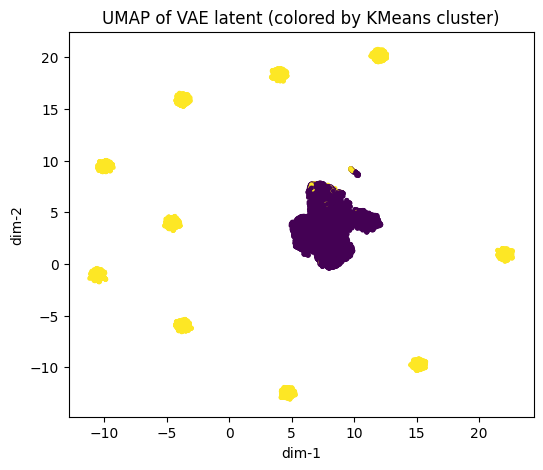

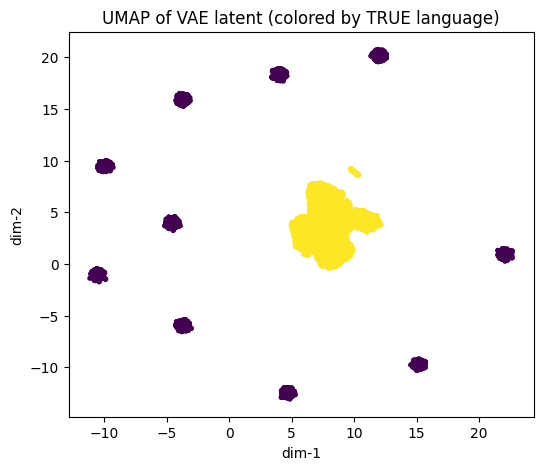

In [24]:
def plot_2d(Z2, title, c, label_name="label"):
    plt.figure(figsize=(6,5))
    plt.scatter(Z2[:,0], Z2[:,1], c=c, s=6)
    plt.title(title)
    plt.xlabel("dim-1"); plt.ylabel("dim-2")
    plt.show()

# For coloring
true_lang = y_lang
pred_cluster = labels_vae

try:
    import umap
    reducer = umap.UMAP(n_components=2, random_state=SEED)
    Z2 = reducer.fit_transform(z_mean_best)
    plot_2d(Z2, "UMAP of VAE latent (colored by KMeans cluster)", pred_cluster, "cluster")
    plot_2d(Z2, "UMAP of VAE latent (colored by TRUE language)", true_lang, "language")
except Exception as e:
    print("UMAP failed, falling back to t-SNE:", e)
    from sklearn.manifold import TSNE
    Z2 = TSNE(n_components=2, random_state=SEED, perplexity=30, init="pca").fit_transform(z_mean_best)
    plot_2d(Z2, "t-SNE of VAE latent (colored by KMeans cluster)", pred_cluster, "cluster")
    plot_2d(Z2, "t-SNE of VAE latent (colored by TRUE language)", true_lang, "language")

In [25]:
# Metrics table (for report)
metrics = pd.DataFrame([
    {"method": "PCA+KMeans", "silhouette": sil_pca, "calinski_harabasz": ch_pca, "ari_optional": ari_pca, "pca_dim": pca_dim},
    {"method": "VAE(best)+KMeans", "silhouette": sil_vae, "calinski_harabasz": ch_vae, "ari_optional": ari_vae,
     "latent_dim": best_latent, "beta": best_beta},
])

metrics_path = OUT_DIR / "easy_task_metrics.csv"
metrics.to_csv(metrics_path, index=False)
print("Saved metrics ->", metrics_path)

# Save sweep results
sweep_path = OUT_DIR / "vae_sweep_results.csv"
df_sweep.to_csv(sweep_path, index=False)
print("Saved sweep ->", sweep_path)

# Save embeddings + labels
np.save(OUT_DIR / "z_mean_best.npy", z_mean_best)
np.save(OUT_DIR / "labels_vae.npy", labels_vae)
np.save(OUT_DIR / "labels_pca.npy", labels_pca)
np.save(OUT_DIR / "y_true_language.npy", y_lang)

# Save meta corresponding to X (so you can trace clips later)
meta_out = OUT_DIR / "meta_used.csv"
meta.to_csv(meta_out, index=False)
print("Saved meta ->", meta_out)

metrics

Saved metrics -> /content/drive/MyDrive/easy_task_outputs/easy_task_metrics.csv
Saved sweep -> /content/drive/MyDrive/easy_task_outputs/vae_sweep_results.csv
Saved meta -> /content/drive/MyDrive/easy_task_outputs/meta_used.csv


,method,silhouette,calinski_harabasz,ari_optional,pca_dim,latent_dim,beta
0,PCA+KMeans,0.292658,10432.978516,0.256017,16.0,NaN,NaN
1,VAE(best)+KMeans,0.172835,5149.244141,0.969567,NaN,8.0,0.5


In [27]:
# labels_vae: predicted clusters from best VAE model
# y_lang: 0=english, 1=bengali

ct = pd.crosstab(pd.Series(y_lang, name="true_language"),
                 pd.Series(labels_vae, name="cluster"))
print("Confusion table (true_language x cluster):")
print(ct)

# cluster -> majority language
cluster_majority = ct.idxmax(axis=0)  # per cluster
cluster_purity = ct.max(axis=0) / ct.sum(axis=0)

print("\nCluster majority language (0=english,1=bengali):")
print(cluster_majority)

print("\nCluster purity per cluster:")
print(cluster_purity)

overall_purity = (ct.max(axis=0).sum()) / ct.values.sum()
print("\nOverall purity:", overall_purity)


Confusion table (true_language x cluster):
cluster            0      1
true_language              
0                  0  15000
1              14770    230

Cluster majority language (0=english,1=bengali):
cluster
0    1
1    0
dtype: int32

Cluster purity per cluster:
cluster
0    1.000000
1    0.984898
dtype: float64

Overall purity: 0.9923333333333333


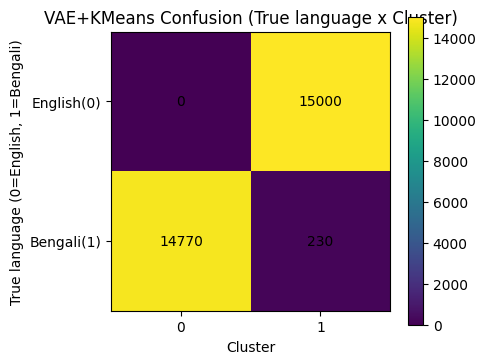

In [28]:
cm = np.array([[0, 15000],
               [14770, 230]])

plt.figure(figsize=(4.5,4))
plt.imshow(cm)
plt.title("VAE+KMeans Confusion (True language x Cluster)")
plt.xlabel("Cluster")
plt.ylabel("True language (0=English, 1=Bengali)")
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, str(cm[i, j]), ha="center", va="center")
plt.xticks([0,1], ["0","1"])
plt.yticks([0,1], ["English(0)","Bengali(1)"])
plt.colorbar()
plt.show()